<a href="https://colab.research.google.com/github/MELAI-1/AIMS-PROJECT/blob/main/notebooks/Timeseries_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **I-GOOGLE ACCOUNT AUTHENTIFICATION**

In [1]:
from google.colab import auth
auth.authenticate_user()


# **II-IMPORT THE REQUIREMENTS LIBRARIES**

In [2]:
! pip install -q -U zarr xarray gcsfs
import xarray as xr
import gcsfs
import zarr
import pandas as pd
import matplotlib.pyplot as plt
import cupy as cp
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.9/203.9 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.7/53.7 kB 3.2 MB/s eta 0:00:00


In [3]:

# define the neuralgcm path data
ngcm_path = 'gs://neuralgcm/amip_runs/v1_precip_stochastic_2_8_deg/2001-to-2021_128x64_gauss_37-level_stride3h.zarr'
#load the data
# ngcm_data = xr.open_zarr(ngcm_path,chunks={"time":100})
ngcm_data = xr.open_zarr(ngcm_path)

<ipython-input-3-cd22bc7a61c8>:5: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ngcm_data = xr.open_zarr(ngcm_path)


In [4]:
#the size of the neural gcm data
ngcm_data.nbytes/1e9

1628.740724872

# **Data Understanding**

In [5]:
ngcm_data.info()

xarray.Dataset {
dimensions:
	time = 37 ;
	prediction_timedelta = 58408 ;
	surface = 1 ;
	longitude = 128 ;
	latitude = 64 ;
	level = 3 ;

variables:
	float32 evaporation(time, prediction_timedelta, surface, longitude, latitude) ;
	float32 geopotential(time, prediction_timedelta, level, longitude, latitude) ;
	float64 latitude(latitude) ;
	int64 level(level) ;
	float64 longitude(longitude) ;
	float32 precipitation_cumulative_mean(time, prediction_timedelta, surface, longitude, latitude) ;
	timedelta64[ns] prediction_timedelta(prediction_timedelta) ;
	float32 specific_cloud_ice_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_cloud_liquid_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_humidity(time, prediction_timedelta, level, longitude, latitude) ;
	int64 surface(surface) ;
	float32 temperature(time, prediction_timedelta, level, longitude, latitude) ;
	datetime64[ns] time(time) ;
	float32 u_component_o

In [6]:
ngcm_data.precipitation_cumulative_mean


<xarray.DataArray 'precipitation_cumulative_mean' (time: 37,
                                                   prediction_timedelta: 58408,
                                                   surface: 1, longitude: 128,
                                                   latitude: 64)> Size: 71GB
dask.array<open_dataset-precipitation_cumulative_mean, shape=(37, 58408, 1, 128, 64), dtype=float32, chunksize=(1, 8, 1, 128, 64), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 512B -87.86 -85.1 ... 85.1 87.86
  * longitude             (longitude) float64 1kB 0.0 2.812 ... 354.4 357.2
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 467kB 00:00:...
  * surface               (surface) int64 8B 1
  * time                  (time) datetime64[ns] 296B 2001-01-01 ... 2001-12-27

In [7]:
#the min and the max values of time in the global neural GCM
print(f"the min date is :",ngcm_data.time.min().values)
print(f"the max date is :",ngcm_data.time.max().values)

the min date is : 2001-01-01T00:00:00.000000000
the max date is : 2001-12-27T00:00:00.000000000


# **neuralGCM data for our domain**

In [8]:
#select Horn Africa data
ngcm_data_africa = ngcm_data.sel(latitude=slice(-20,30),longitude=slice(15,60))


In [11]:
#the size of the horn africa data in GO
ngcm_data_africa.nbytes/1e9

57.26086748

In [10]:
#the prediction time
ngcm_data_africa.prediction_timedelta.indexes

Indexes:
    prediction_timedelta  TimedeltaIndex([   '0 days 00:00:00',    '0 days 03:00:00',
                   '0 days 06:00:00',    '0 days 09:00:00',
                   '0 days 12:00:00',    '0 days 15:00:00',
                   '0 days 18:00:00',    '0 days 21:00:00',
                   '1 days 00:00:00',    '1 days 03:00:00',
                ...
                '7299 days 18:00:00', '7299 days 21:00:00',
                '7300 days 00:00:00', '7300 days 03:00:00',
                '7300 days 06:00:00', '7300 days 09:00:00',
                '7300 days 12:00:00', '7300 days 15:00:00',
                '7300 days 18:00:00', '7300 days 21:00:00'],
               dtype='timedelta64[ns]', name='prediction_timedelta', length=58408, freq=None)

# we can now selected the 6h time delta

In [15]:
#select the climate timeset where prediction_timedelta is a multiple of 6h

# Convert prediction_timedelta to a pandas Series for easier manipulation
prediction_timedelta_series = pd.Series(ngcm_data_africa.prediction_timedelta.values)

# Select values where prediction_timedelta is a multiple of 6 hours (in seconds)
selected_indices = prediction_timedelta_series[prediction_timedelta_series % pd.Timedelta(hours=6) == pd.Timedelta(0)].index

# Use the selected indices to filter the entire dataset
selected_data = ngcm_data_africa.isel(prediction_timedelta=selected_indices)

selected_data

<xarray.Dataset> Size: 29GB
Dimensions:                              (time: 37,
                                          prediction_timedelta: 29204,
                                          surface: 1, longitude: 16,
                                          latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
  * time                                 (time) datetime64[ns] 296B 2001-01-0...
Data variables:
    evaporation                          (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 4GB dask.array<chunksize=(1, 8, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [18]:
selected_data.nbytes/1e9

28.63043404

In [19]:
print(selected_data.info())

xarray.Dataset {
dimensions:
	time = 37 ;
	prediction_timedelta = 29204 ;
	surface = 1 ;
	longitude = 16 ;
	latitude = 18 ;
	level = 3 ;

variables:
	float32 evaporation(time, prediction_timedelta, surface, longitude, latitude) ;
	float32 geopotential(time, prediction_timedelta, level, longitude, latitude) ;
	float64 latitude(latitude) ;
	int64 level(level) ;
	float64 longitude(longitude) ;
	float32 precipitation_cumulative_mean(time, prediction_timedelta, surface, longitude, latitude) ;
	timedelta64[ns] prediction_timedelta(prediction_timedelta) ;
	float32 specific_cloud_ice_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_cloud_liquid_water_content(time, prediction_timedelta, level, longitude, latitude) ;
	float32 specific_humidity(time, prediction_timedelta, level, longitude, latitude) ;
	int64 surface(surface) ;
	float32 temperature(time, prediction_timedelta, level, longitude, latitude) ;
	datetime64[ns] time(time) ;
	float32 u_component_of

In [22]:
# Sélect one level and one surface(surface=1, level=0)
ds_subset = selected_data.sel(level=selected_data.level[0])
ds_subset

<xarray.Dataset> Size: 11GB
Dimensions:                              (time: 37,
                                          prediction_timedelta: 29204,
                                          surface: 1, longitude: 16,
                                          latitude: 18)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
    level                                int64 8B 500
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
  * time                                 (time) datetime64[ns] 296B 2001-01-0...
Data variables:
    evaporation                          (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (time, prediction_timedelta, surface, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 16, 18), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 16, 18), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, longitude, latitude) float32 1GB dask.array<chunksize=(1, 8, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [23]:
ds_subset.nbytes/1e9

11.20335588

In [24]:
# Définir le device (GPU si disponible, sinon CPU)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [26]:
# tenir compte de la derniere valeur de time
small_data = selected_data.isel(time=-1)

In [27]:
small_data.nbytes/1e9

0.774023128

In [28]:
small_data

<xarray.Dataset> Size: 774MB
Dimensions:                              (prediction_timedelta: 29204,
                                          surface: 1, longitude: 16,
                                          latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
    temperature                          (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [29]:
small_data.evaporation.isel(prediction_timedelta=6)

<xarray.DataArray 'evaporation' (surface: 1, longitude: 16, latitude: 18)> Size: 1kB
dask.array<getitem, shape=(1, 16, 18), dtype=float32, chunksize=(1, 16, 18), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 144B -18.14 -15.35 ... 26.51 29.3
  * longitude             (longitude) float64 128B 16.88 19.69 ... 56.25 59.06
    prediction_timedelta  timedelta64[ns] 8B 1 days 12:00:00
  * surface               (surface) int64 8B 1
    time                  datetime64[ns] 8B 2001-12-27

In [30]:
small_data.prediction_timedelta.dt.days

<xarray.DataArray 'days' (prediction_timedelta: 29204)> Size: 234kB
array([   0,    0,    0, ..., 7300, 7300, 7300])
Coordinates:
  * prediction_timedelta  (prediction_timedelta) timedelta64[ns] 234kB 00:00:...
    time                  datetime64[ns] 8B 2001-12-27

In [31]:
small_data

<xarray.Dataset> Size: 774MB
Dimensions:                              (prediction_timedelta: 29204,
                                          surface: 1, longitude: 16,
                                          latitude: 18, level: 3)
Coordinates:
  * latitude                             (latitude) float64 144B -18.14 ... 29.3
  * level                                (level) int64 24B 500 700 850
  * longitude                            (longitude) float64 128B 16.88 ... 5...
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 234kB ...
  * surface                              (surface) int64 8B 1
    time                                 datetime64[ns] 8B 2001-12-27
Data variables:
    evaporation                          (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    geopotential                         (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
    precipitation_cumulative_mean        (prediction_timedelta, surface, longitude, latitude) float32 34MB dask.array<chunksize=(8, 1, 16, 18), meta=np.ndarray>
    specific_cloud_ice_water_content     (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
    specific_cloud_liquid_water_content  (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
    specific_humidity                    (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
    temperature                          (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
    u_component_of_wind                  (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
    v_component_of_wind                  (prediction_timedelta, level, longitude, latitude) float32 101MB dask.array<chunksize=(8, 3, 16, 18), meta=np.ndarray>
Attributes:
    experiment_id:  121052169
    worker_id:      2

In [ ]:
#compute the group of variable per year
evaporation_group_year = small_data.evaporation.groupby(small_data.prediction_timedelta.dt.days//365)
temperature_group_year = small_data.temperature.groupby(small_data.prediction_timedelta.dt.days//365)
geopotential_group_year= small_data.geopotential.groupby(small_data.prediction_timedelta.dt.days//365)
precipitation_cumulative_mean_group_year= small_data.precipitation_cumulative_mean.groupby(small_data.prediction_timedelta.dt.days//365)
specific_cloud_ice_water_content_group_year= small_data.specific_cloud_ice_water_content.groupby(small_data.prediction_timedelta.dt.days//365)
specific_cloud_liquid_water_content_group_year= small_data.specific_cloud_liquid_water_content.groupby(small_data.prediction_timedelta.dt.days//365)
specific_humidity_group_year= small_data.specific_humidity.groupby(small_data.prediction_timedelta.dt.days//365)
u_component_of_wind_group_year= small_data.u_component_of_wind.groupby(small_data.prediction_timedelta.dt.days//365)
v_component_of_wind_group_year= small_data.v_component_of_wind.groupby(small_data.prediction_timedelta.dt.days//365)



In [ ]:
evaporation_group_year[3].mean(dim=('prediction_timedelta','longitude','latitude')).values[0]

np.float32(-2.7177643e-05)

In [ ]:
#compute the mean of each variables per year
import tqdm as tqdm
evaporation_mean_year=[]
for i in tqdm.tqdm(range(len(evaporation_group_year))):
  evaporation_mean_year.append(evaporation_group_year[i].mean(dim=('prediction_timedelta','longitude','latitude')).values[0])

100%|██████████| 21/21 [07:03<00:00, 20.17s/it]


In [ ]:
temperature_mean_year=[]
for i in tqdm.tqdm(range(len(temperature_group_year))):
  temperature_mean_year.append(temperature_group_year[i].mean(dim=('prediction_timedelta','longitude','latitude')).values[0])

100%|██████████| 21/21 [09:34<00:00, 27.37s/it]


In [ ]:
geopotential_mean_year=[]
for i in tqdm.tqdm(range(len(geopotential_group_year))):
  geopotential_mean_year.append(geopotential_group_year[i].mean(dim=('prediction_timedelta','longitude','latitude')).values[0])

100%|██████████| 21/21 [09:40<00:00, 27.65s/it]


In [ ]:
precipitation_cumulative_mean_mean_year=[]
for i in tqdm.tqdm(range(len(precipitation_cumulative_mean_group_year))):
  precipitation_cumulative_mean_mean_year.append(precipitation_cumulative_mean_group_year[i].mean(dim=('prediction_timedelta','longitude','latitude')).values[0])

In [ ]:
specific_cloud_ice_water_content_mean_year=[]
for i in tqdm.tqdm(range(len(specific_cloud_ice_water_content_group_year))):
  specific_cloud_ice_water_content_mean_year.append(specific_cloud_ice_water_content_group_year[i].mean(dim=('prediction_timedelta','longitude','latitude')).values[0])

In [ ]:
years = range(2001, 2022)
print(list(years))


[2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


In [ ]:

# Create a pandas Series for easier plotting
evaporation_series = pd.Series(evaporation_mean_year)

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(years, evaporation_series.values, marker='o', linestyle='-')  # Add markers and lines

# Annotate each point with its actual value
for i, year in enumerate(years):
    plt.annotate(f'{evaporation_mean_year[i]:.2f}', (year, evaporation_mean_year[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Time Series of Mean Evaporation', fontsize=16) # Set title with fontsize
plt.xlabel('Year', fontsize=12) # Set x label with fontsize
plt.ylabel('Mean Evaporation', fontsize=12) # Set y label with fontsize
plt.grid(True)  # Add grid lines
plt.xticks(list(years)) # Ensure all x-axis values are displayed
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


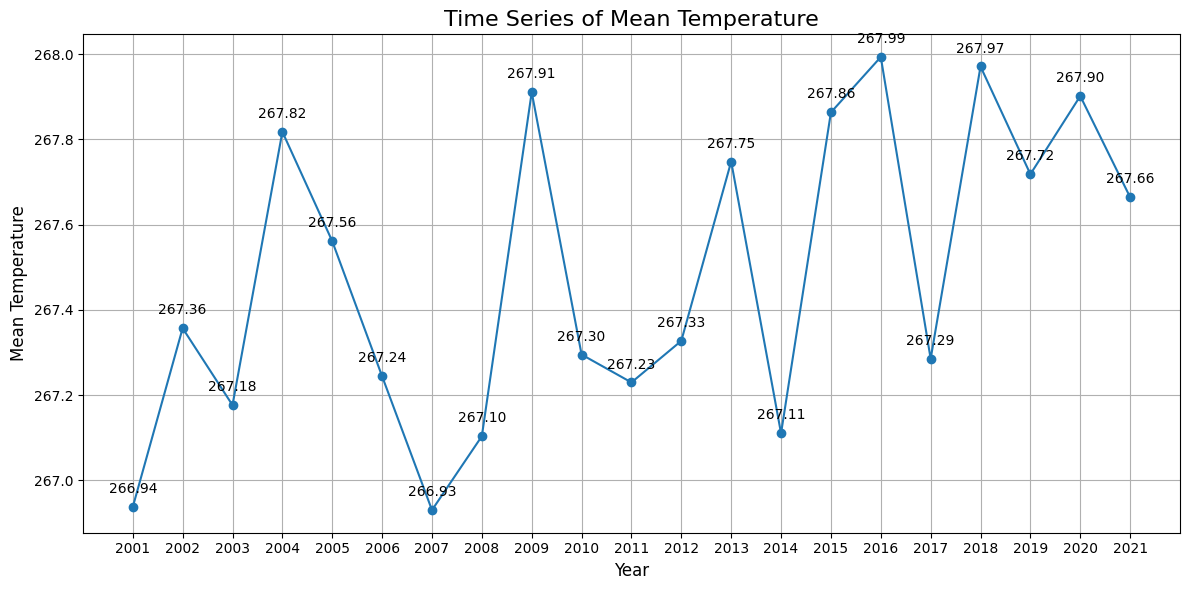

In [ ]:

# Create a pandas Series for easier plotting
temperature_series = pd.Series(temperature_mean_year)

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(years, temperature_series.values, marker='o', linestyle='-')  # Add markers and lines

# Annotate each point with its value
for i, txt in enumerate(temperature_mean_year):
    plt.annotate(f"{txt:.2f}", (years[i], temperature_series.values[i]), textcoords="offset points", xytext=(0,10), ha='center')

plt.title('Time Series of Mean Temperature', fontsize=16) # Set title with fontsize
plt.xlabel('Year', fontsize=12) # Set x label with fontsize
plt.ylabel('Mean Temperature', fontsize=12) # Set y label with fontsize
plt.grid(True)  # Add grid lines
plt.xticks(list(years)) # Ensure all x-axis values are displayed
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


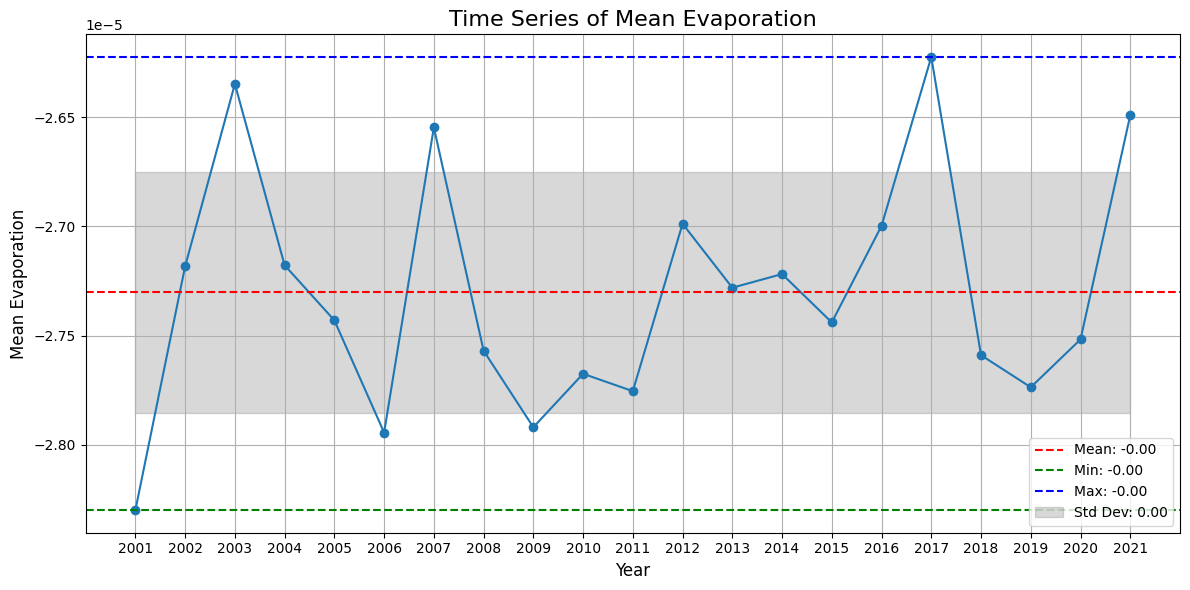

In [ ]:

# Create a pandas Series for easier plotting
evaporation_series = pd.Series(evaporation_mean_year)

# Calculate statistics
mean_evaporation = evaporation_series.mean()
min_evaporation = evaporation_series.min()
max_evaporation = evaporation_series.max()
std_evaporation = evaporation_series.std()

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(years, evaporation_series.values, marker='o', linestyle='-')  # Add markers and lines

# Add horizontal lines for mean, min, max, and std
plt.axhline(mean_evaporation, color='red', linestyle='--', label=f'Mean: {mean_evaporation:.2f}')
plt.axhline(min_evaporation, color='green', linestyle='--', label=f'Min: {min_evaporation:.2f}')
plt.axhline(max_evaporation, color='blue', linestyle='--', label=f'Max: {max_evaporation:.2f}')

plt.fill_between(years, mean_evaporation - std_evaporation, mean_evaporation + std_evaporation, color='gray', alpha=0.3, label=f'Std Dev: {std_evaporation:.2f}')


plt.title('Time Series of Mean Evaporation', fontsize=16) # Set title with fontsize
plt.xlabel('Year', fontsize=12) # Set x label with fontsize
plt.ylabel('Mean Evaporation', fontsize=12) # Set y label with fontsize
plt.grid(True)  # Add grid lines
plt.xticks(list(years)) # Ensure all x-axis values are displayed
plt.legend() # Show the legend for the lines
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


In [ ]:
# Function to plot with annotations and statistics
def plot_with_stats(data, title, ylabel):
    series = pd.Series(data)
    mean_val = series.mean()
    min_val = series.min()
    max_val = series.max()
    std_val = series.std()

    plt.figure(figsize=(12, 6))
    plt.plot(years, series.values, marker='o', linestyle='-')

    for i, year in enumerate(years):
        plt.annotate(f'{data[i]:.2f}', (year, data[i]), textcoords="offset points", xytext=(0, 10), ha='center')

    plt.axhline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axhline(min_val, color='green', linestyle='--', label=f'Min: {min_val:.2f}')
    plt.axhline(max_val, color='blue', linestyle='--', label=f'Max: {max_val:.2f}')
    plt.fill_between(years, mean_val - std_val, mean_val + std_val, color='gray', alpha=0.3, label=f'Std Dev: {std_val:.2f}')

    plt.title(title, fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.xticks(list(years))
    plt.legend()
    plt.tight_layout()
    plt.show()


# Call the function for Evaporation
plot_with_stats(evaporation_mean_year, 'Time Series of Mean Evaporation', 'Mean Evaporation')

# Call the function for Temperature
plot_with_stats(temperature_mean_year, 'Time Series of Mean Temperature', 'Mean Temperature')


In [ ]:
# Create a pandas Series for easier plotting
temperature_series = pd.Series(temperature_mean_year)

# Create the plot
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(years, evaporation_series.values, marker='o', linestyle='-')  # Add markers and lines
plt.title('Time Series of Mean temperature', fontsize=16) # Set title with fontsize
plt.xlabel('Year', fontsize=12) # Set x label with fontsize
plt.ylabel('Mean Evaporation', fontsize=12) # Set y label with fontsize
plt.grid(True)  # Add grid lines
plt.xticks(list(years)) # Ensure all x-axis values are displayed
plt.tight_layout() # Adjust layout to prevent labels from overlapping


plt.show()

In [ ]:
# Create a list to store the years
years = list(range(2001, 2022))

# Create empty lists to store the mean values for each variable
evaporation_means = []
temperature_means = []
geopotential_means = []
precipitation_means = []
specific_cloud_ice_water_content_means = []
specific_cloud_liquid_water_content_means = []
specific_humidity_means = []
u_component_of_wind_means = []
v_component_of_wind_means = []


# Assuming evaporation_group_year, etc., are defined as in your provided code
for year_index in tqdm.tqdm(range(len(evaporation_group_year))):
    evaporation_means.append(evaporation_group_year[year_index].mean(dim=('prediction_timedelta', 'longitude', 'latitude')).values[0])
    temperature_means.append(temperature_group_year[year_index].mean(dim=('prediction_timedelta', 'longitude', 'latitude')).values[0])
    geopotential_means.append(geopotential_group_year[year_index].mean(dim=('prediction_timedelta', 'longitude', 'latitude')).values[0])
    precipitation_means.append(precipitation_cumulative_mean_group_year[year_index].mean(dim=('prediction_timedelta', 'longitude', 'latitude')).values[0])
    specific_cloud_ice_water_content_means.append(specific_cloud_ice_water_content_group_year[year_index].mean(dim=('prediction_timedelta', 'longitude', 'latitude')).values[0])
    specific_cloud_liquid_water_content_means.append(specific_cloud_liquid_water_content_group_year[year_index].mean(dim=('prediction_timedelta', 'longitude', 'latitude')).values[0])
    specific_humidity_means.append(specific_humidity_group_year[year_index].mean(dim=('prediction_timedelta', 'longitude', 'latitude')).values[0])
    u_component_of_wind_means.append(u_component_of_wind_group_year[year_index].mean(dim=('prediction_timedelta', 'longitude', 'latitude')).values[0])
    v_component_of_wind_means.append(v_component_of_wind_group_year[year_index].mean(dim=('prediction_timedelta', 'longitude', 'latitude')).values[0])




In [ ]:
Create the DataFrame
df = pd.DataFrame({
    'Year': years,
    'Evaporation': evaporation_means,
    'Temperature': temperature_means,
    'Geopotential': geopotential_means,
    'Precipitation': precipitation_means,
    'Specific_Cloud_Ice_Water_Content': specific_cloud_ice_water_content_means,
    'Specific_Cloud_Liquid_Water_Content': specific_cloud_liquid_water_content_means,
    'Specific_Humidity': specific_humidity_means,
    'U_Component_of_Wind': u_component_of_wind_means,
    'V_Component_of_Wind': v_component_of_wind_means,
})

df

In [ ]:

from google.colab import files
df.to_csv('ngcm_mean_variables.csv', encoding = 'utf-8-sig')
files.download('ngcm_mean_variables.csv')


In [ ]:
import pandas as pd
# Load the dataframe from the CSV file
df = pd.read_csv('ngcm_mean_variables.csv')
#remove the index column if present
df = df.drop(df.columns[0], axis=1)
df

,Year,Evaporation,Temperature,Geopotential,Precipitation,Specific_Cloud_Ice_Water_Content,Specific_Cloud_Liquid_Water_Content,Specific_Humidity,U_Component_of_Wind,V_Component_of_Wind
0,2001,-0.000028,266.93768,57505.880,0.400873,1.068847e-06,0.000009,0.001438,1.468133,-0.381264
1,2002,-0.000027,267.35710,57568.625,1.214248,9.435697e-07,0.000009,0.001538,1.563968,-0.309005
2,2003,-0.000026,267.17664,57550.150,2.005824,9.096959e-07,0.000008,0.001414,1.972763,-0.184781
3,2004,-0.000027,267.81772,57620.203,2.811799,8.044467e-07,0.000009,0.001550,1.794583,-0.310050
4,2005,-0.000027,267.56110,57571.730,3.661214,9.641617e-07,0.000009,0.001465,1.783995,-0.216201
5,2006,-0.000028,267.24435,57502.977,4.514099,9.813625e-07,0.000009,0.001535,1.628011,-0.422214
6,2007,-0.000027,266.93057,57444.150,5.325723,9.460319e-07,0.000009,0.001406,1.373758,-0.392004
7,2008,-0.000028,267.10376,57553.690,6.106673,1.014295e-06,0.000009,0.001430,1.991848,-0.495365
8,2009,-0.000028,267.91050,57623.120,6.919768,8.291424e-07,0.000009,0.001488,1.551841,-0.198690
9,2010,-0.000028,267.29526,57480.740,7.693239,9.658954e-07,0.000009,0.001405,1.313283,-0.228710


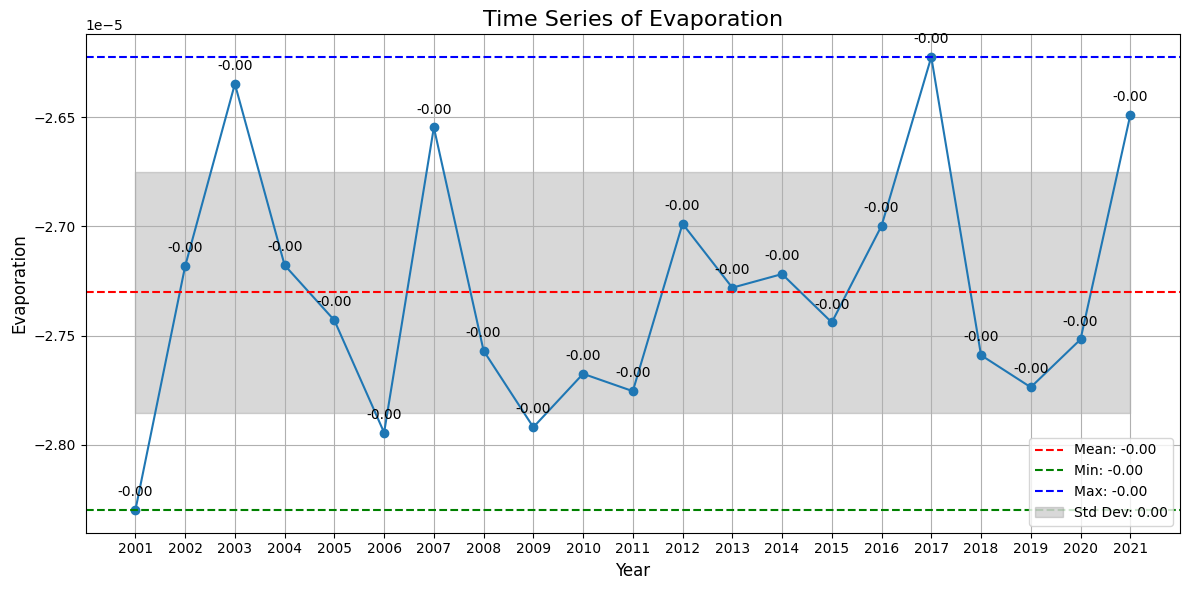

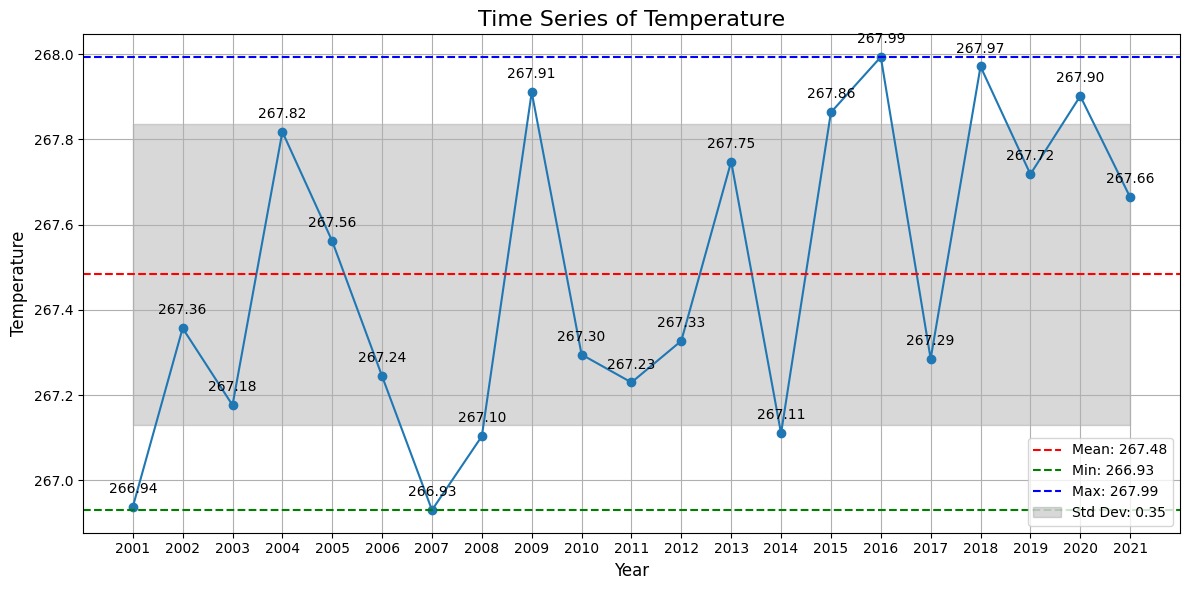

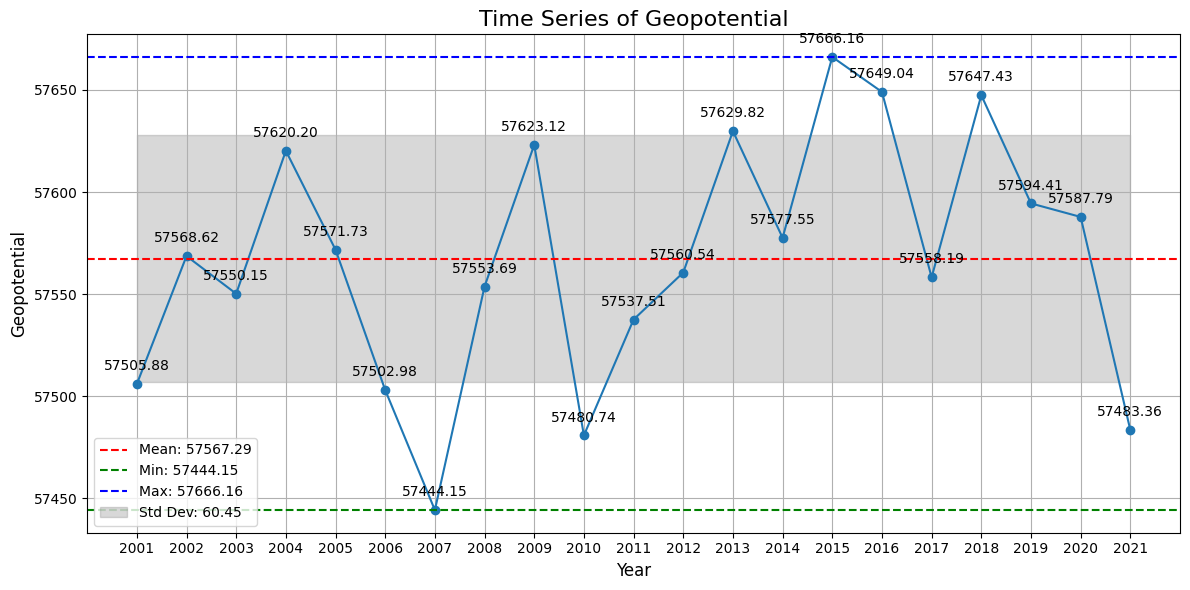

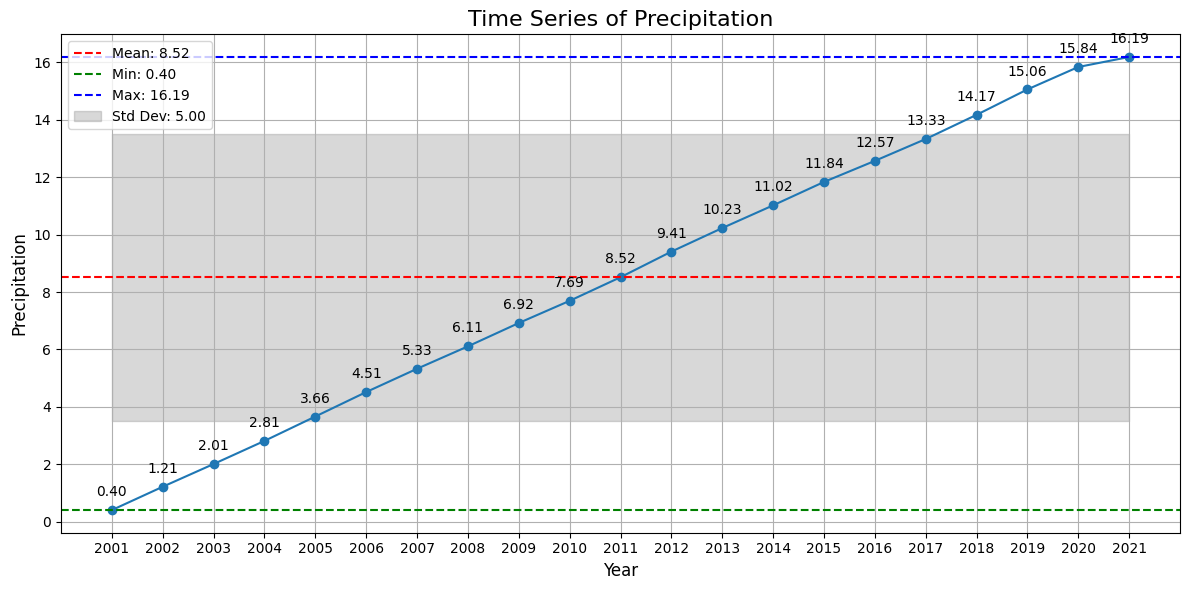

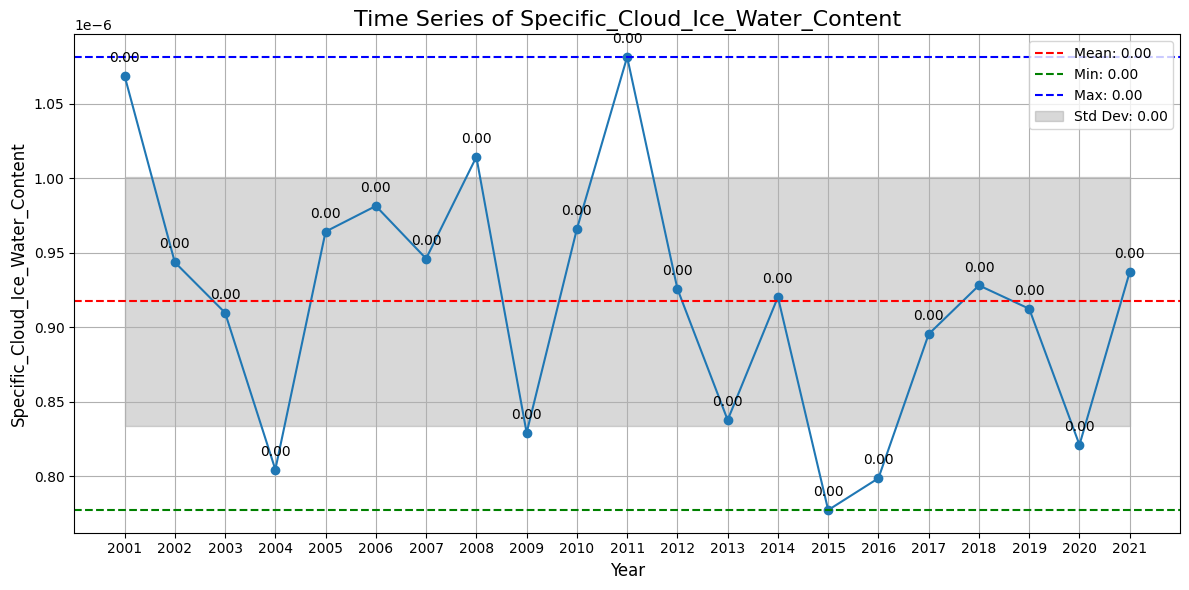

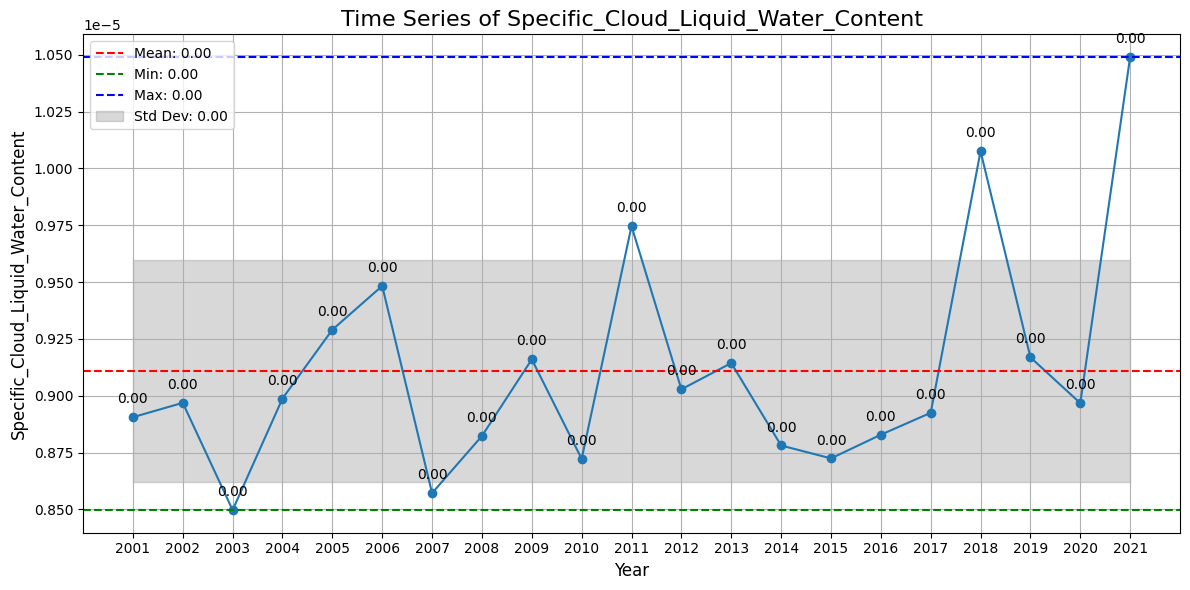

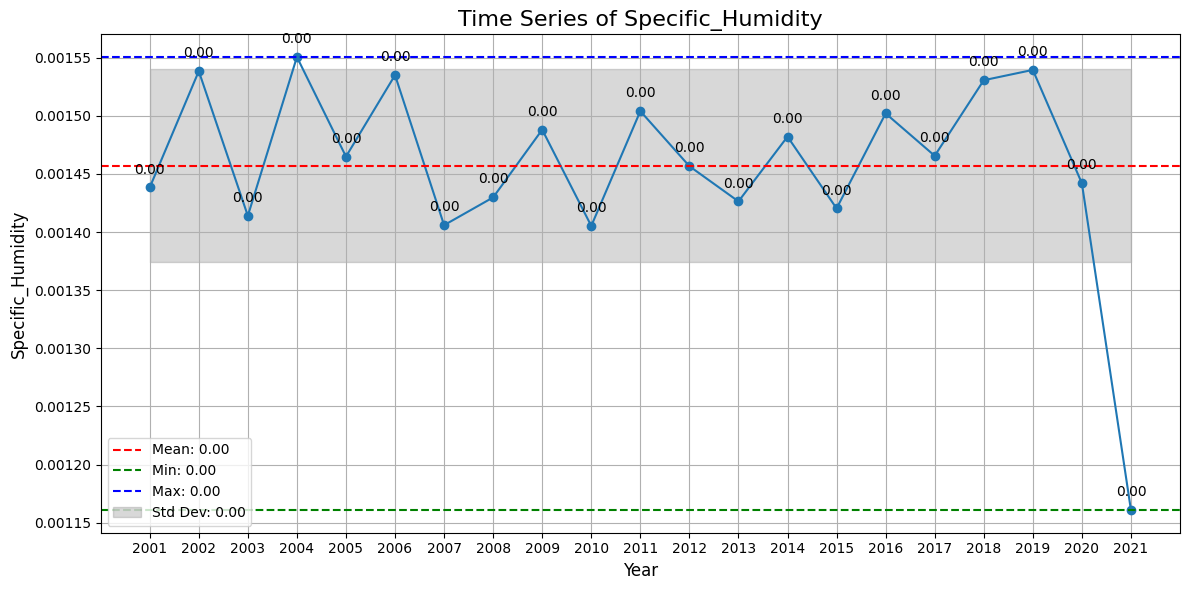

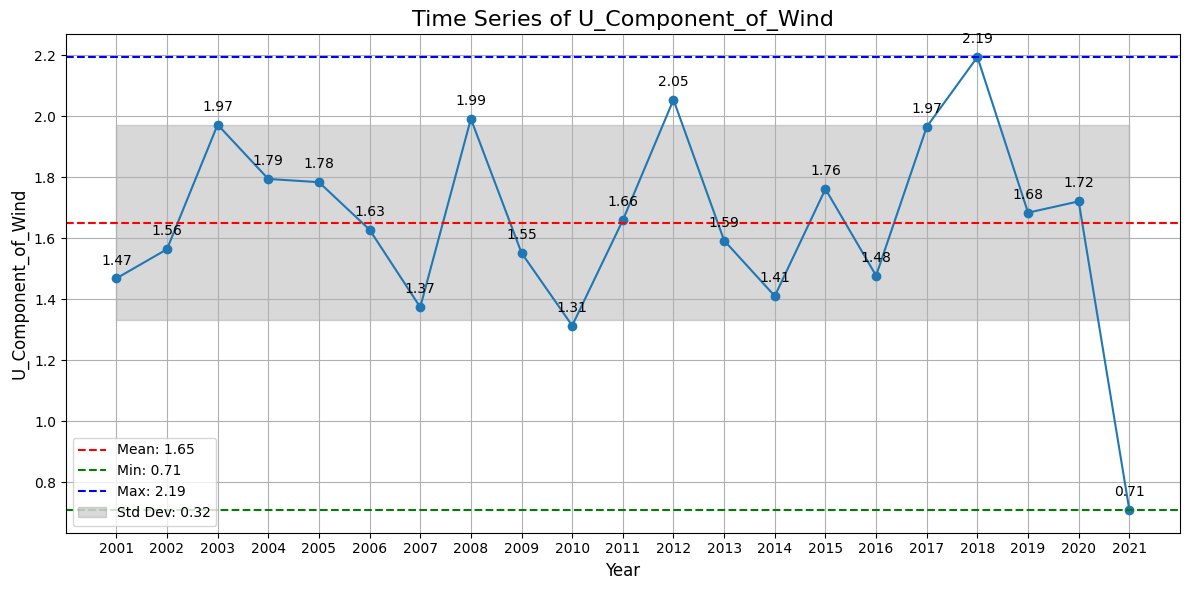

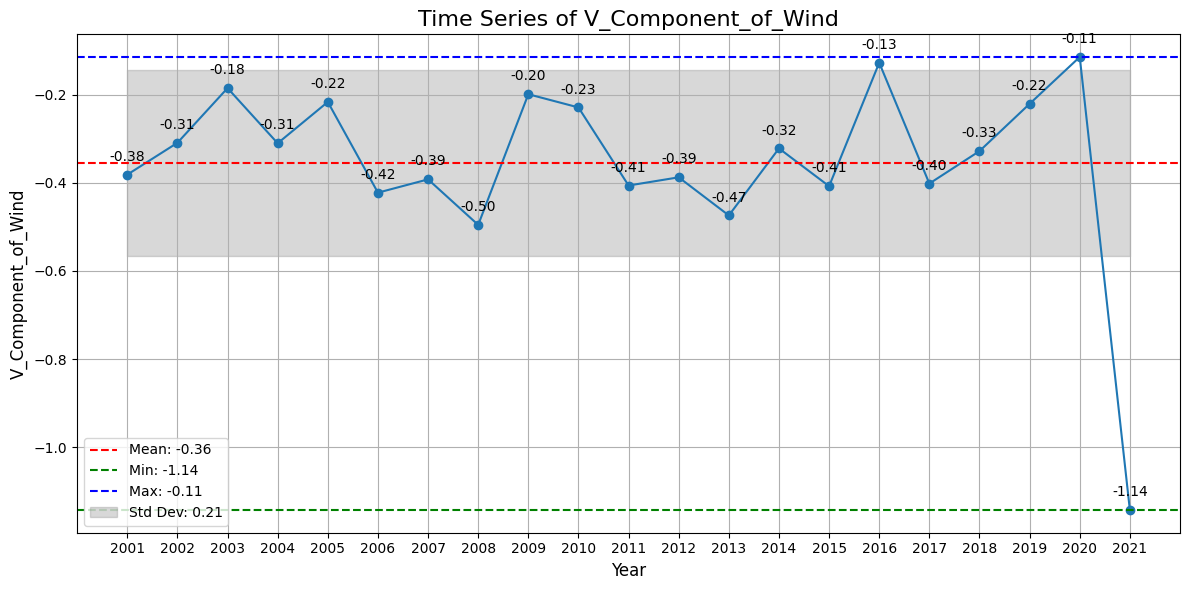

In [ ]:

import matplotlib.pyplot as plt
# Function to plot with annotations and statistics
def plot_with_stats(data, title, ylabel):
    series = pd.Series(data)
    mean_val = series.mean()
    min_val = series.min()
    max_val = series.max()
    std_val = series.std()
    plt.figure(figsize=(12, 6))
    plt.plot(years, series.values, marker='o', linestyle='-')
    for i, year in enumerate(years):
        plt.annotate(f'{data[i]:.2f}', (year, data[i]), textcoords="offset points", xytext=(0, 10), ha='center')
    plt.axhline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
    plt.axhline(min_val, color='green', linestyle='--', label=f'Min: {min_val:.2f}')
    plt.axhline(max_val, color='blue', linestyle='--', label=f'Max: {max_val:.2f}')
    plt.fill_between(years, mean_val - std_val, mean_val + std_val, color='gray', alpha=0.3, label=f'Std Dev: {std_val:.2f}')
    plt.title(title, fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True)
    plt.xticks(list(years))
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage with the dataframe:
years = df['Year'].values.tolist()

# Plotting for each variables
for col in df.columns:
    if col != 'Year':
        plot_with_stats(df[col].values.tolist(), f'Time Series of {col}', col)
